# <span style="color:steelblue">Entrega Ejericio series de tiempo</span>

Hecho por: Daniel Piñeres y Maria Paula Alvarez


Fecha: 2024-04-11

# <span style="color:white">Librerias</span>

In [1]:
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# Suprimir advertencias de convergencia de statsmodels
warnings.simplefilter('ignore', ConvergenceWarning)

#!pip install yahoo_fin
#!pip install requests_html
#!pip install yfinance

import yfinance as yf
from yahoo_fin.stock_info import get_data
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from yahoo_fin.stock_info import get_data
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.graphics.tsaplots import plot_predict
from sklearn.metrics import r2_score
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
import seaborn as sns

Warning - Certain functionality 
             requires requests_html, which is not installed.
             
             Install using: 
             pip install requests_html
             
             After installation, you may have to restart your Python session.


In [2]:
# Función para calcular métricas de precisión de las predicciones
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual) / np.abs(actual))  # MAPE
    mae = np.mean(np.abs(forecast - actual))                    # MAE
    rmse = np.sqrt(mean_squared_error(actual, forecast))        # RMSE
    mse = mean_squared_error(actual, forecast)                  # MSE
    r2 = r2_score(actual, forecast)                             # R2
    return {'MAPE': mape, 'MAE': mae, 'RMSE': rmse, 'MSE': mse, 'R2': r2}

### 1.Considere la serie de tiempo asociada con los futuros de la criptomoneda Bitcoin desde que comenzó a comercializarse hasta la fecha del día de hoy. Utilice la API de <span style ="color:BlueViolet">Yahoo Finance</span> para obtener esta serie de tiempo.

In [3]:
stock ='BTC-USD'
resolution = '1d'
end_date = datetime.now()
start_date = datetime(1900, 1, 1) 

Se escoge la fecha más lejana posible para asegurar tener la fecha de creación del stock en <span style ="color:BlueViolet">Yahoo Finance</span>


In [4]:
def date_format(date_h):
    return date_h.strftime('%d/%m/%Y')

In [5]:
BTC_df = get_data(stock,start_date=start_date,end_date=end_date,interval=resolution,index_as_date=False)
BTC_df = BTC_df[:500]
close_prices = BTC_df['close']
BTC_df.head()

,date,open,high,low,close,adjclose,volume,ticker
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0,BTC-USD
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0,BTC-USD
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0,BTC-USD
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0,BTC-USD
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0,BTC-USD


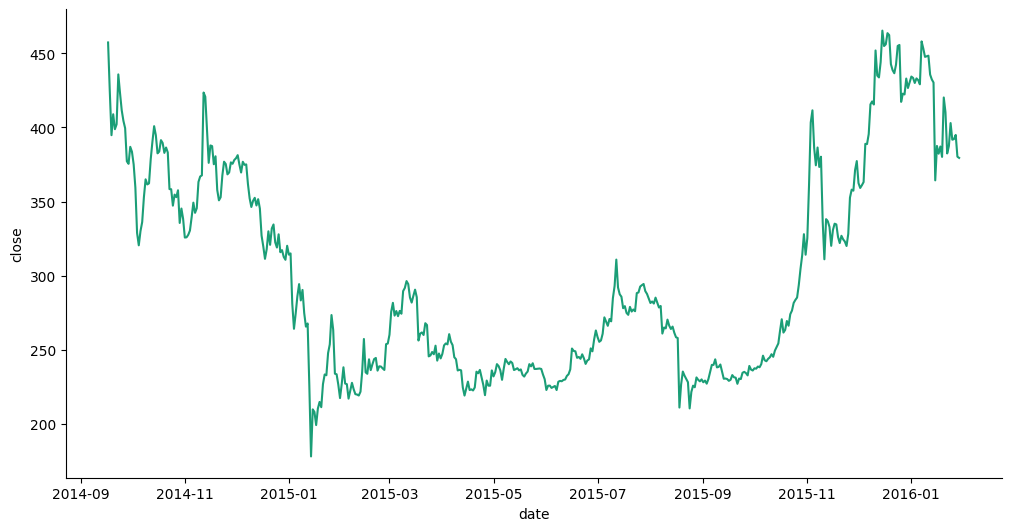

In [6]:
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['close']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = BTC_df.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('close')

Verificación de estacionaridedad de la serie de tiempo.

In [7]:
result = adfuller(BTC_df.close)
print('ADF Statistic: %f' % result[0])
print('p value: %f' % result[1])

ADF Statistic: -1.882474
p value: 0.340350


Ya que el p-value> 0.05 no se rechaza la hipotesis nula y por lo tanto se concluye que la serie de tiempo es no estacionaria. Al ser *<span style ="color:red">no</span>* estacionaria, se deben tomar medidas para convertirla en estacionaria antes de aplicar un modelo ARIMA. Esto implica diferenciar la serie, es decir, transformar la serie tomando la diferencia de observaciones consecutivas.

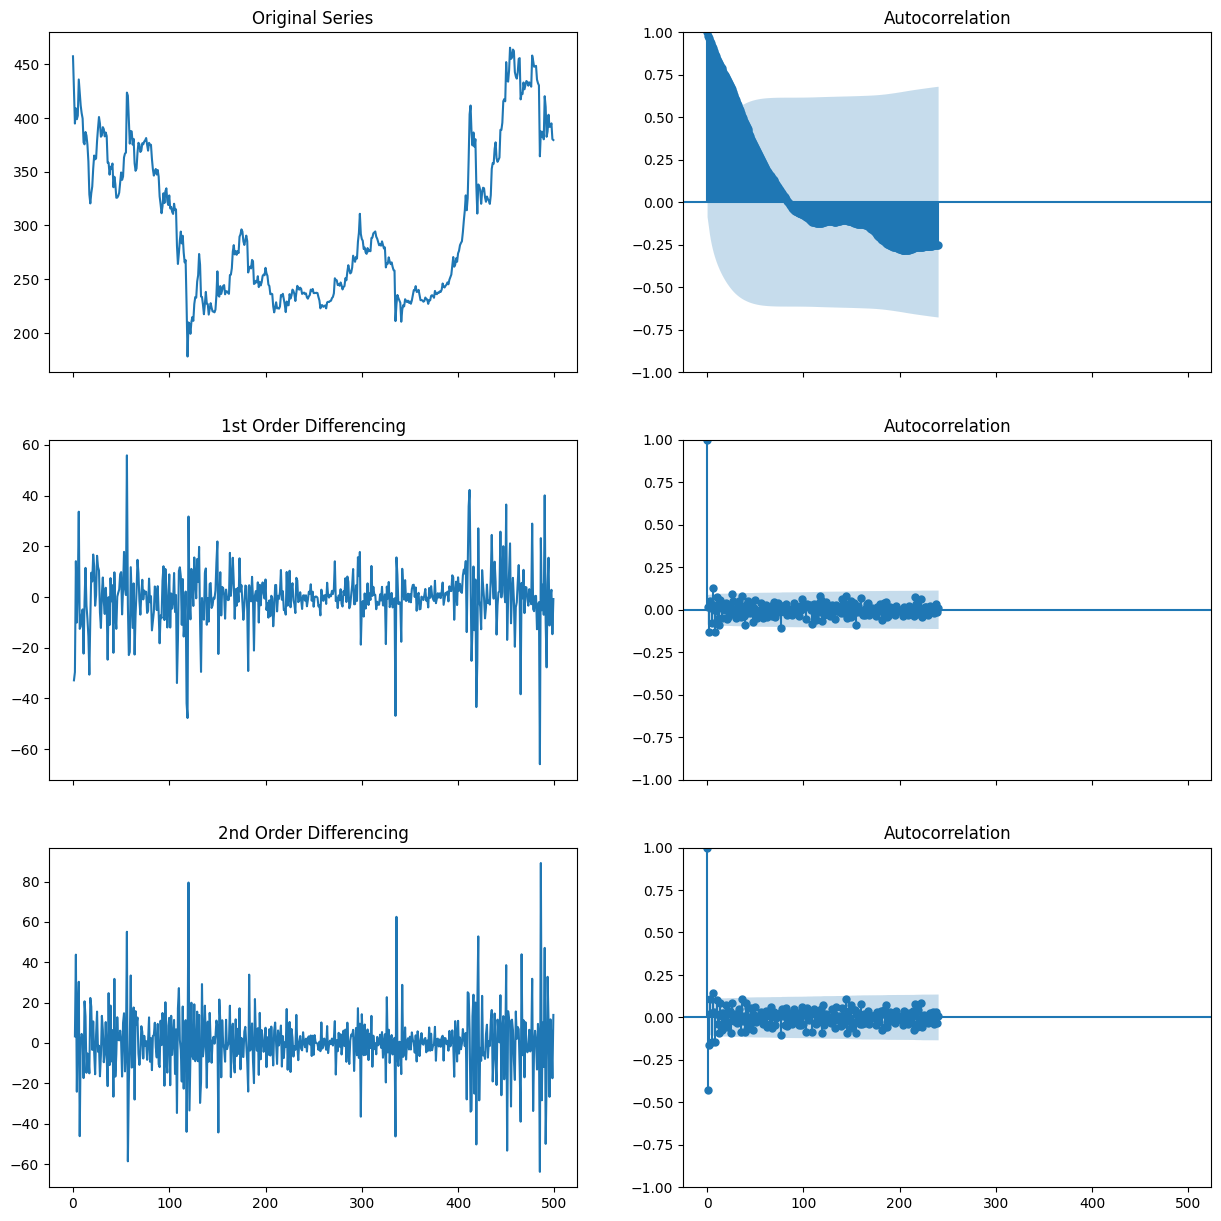

In [8]:
plt.rcParams.update({'figure.figsize': (15,15)})

fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(BTC_df.close); axes[0, 0].set_title('Original Series')
plot_acf(BTC_df.close, ax=axes[0, 1], lags = 240);

axes[1, 0].plot(BTC_df.close.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(BTC_df.close.diff().dropna(), ax=axes[1, 1], lags = 240);

axes[2, 0].plot(BTC_df.close.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(BTC_df.close.diff().diff().dropna(), ax=axes[2, 1], lags = 240);

Se realiza la primera diferencia para llevar la serie a la estacionaridad, si la primera no es suficiente se puede considerar diferenciación de segundo orden, hasta conseguir un valor p > 0.05  

In [9]:
data_diff1 = BTC_df["close"].diff().dropna() # Se utiliza para calcular la diferencia de una serie con su valor previo,  el primer elemento de la serie resultante siempre será NaN porque no hay un elemento anterior del cual restarlo.

result_diff1 = adfuller(data_diff1)
print('ADF Statistic:', result_diff1[0])
print('p-value:', result_diff1[1])

ADF Statistic: -8.169810609208525
p-value: 8.683833628506592e-13


El valor p es menor que 0.05 por lo que no se rechaza la hipotesis nula y se concluye que la serie es estacionaria, lo que significa que tiene propiedas estacionarias y la la media y la varianza no varían con el tiempo, lo que lo hace más predecible.

In [10]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual) / np.abs(actual))
    mae = np.mean(np.abs(forecast - actual))
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    mse = mean_squared_error(actual, forecast)
    r2 = r2_score(actual, forecast)
    return {'MAPE': mape, 'MAE': mae, 'RMSE': rmse, 'MSE': mse, 'R2': r2}

### 2. Repita TODOS los pasos indicados en esta sección para encontrar modelos ARIMA para predecir el precio de Bitcoin con los siguientes horizontes: 7, 14, 21 y 28 días. Utilizar siempre predicciones usando rolling con ventana de predicción continua de un día. Cualquier cantidad de pasos extra para enriquecer su análisis predictivo serán aceptados siempre y cuando sean acordes con lo que indica la teoría de análisis de series de tiempo.

In [11]:
n_BTC = len(BTC_df.close); n_test = 28
train_size = n_BTC - n_test
train = BTC_df.close[:train_size]
dates_train = BTC_df.date[:train_size]
test_4w = BTC_df.close[train_size:train_size + n_test] 
dates_4w = BTC_df.date[train_size:train_size + n_test] 
print("train:", train.shape)
print("test_4w:", test_4w.shape)

train: (472,)
test_4w: (28,)


In [12]:
best_aic = np.inf
best_bic = np.inf

best_order = None
best_mdl = None

pq_rng = range(8)
d_rng  = range(3)

for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                # print(i, d, j)
                tmp_mdl = ARIMA(train, order=(i,d,j)).fit()
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue

In [13]:
best_order

(4, 1, 2)

In [14]:
best_order =(7, 2, 7)

Rolling forecasting  para predecir cifras futuras de forma continua durante un periodo de tiempo, este caso se utilizaran los periodos 7, 14,21 y 28 días.

In [15]:
def rolling_arima_forecast(close_prices, horizons):
    results = {}
    residualsro = []
    for horizon in horizons:
        history = close_prices[:-horizon].tolist()  # Asegúrate de que close_prices es una lista
        test = close_prices[-horizon:]
        predictions = []

        for t in range(len(test)):
            model = ARIMA(history, order=best_order)
            model_fit = model.fit()
            yhat = model_fit.forecast()[0]
            predictions.append(yhat)
            history.append(test.iloc[t])  # Usar .iloc[t] para acceso posicional seguro en Pandas
            
        residualsro.extend(np.array(predictions) - np.array(test))
        accuracy = forecast_accuracy(np.array(predictions), test)
        results[horizon] = {'Forecast': predictions, 'Accuracy': accuracy}

    return results, residualsro

In [16]:
# Horizontes de pronóstico
horizons = [7, 14, 21, 28]

# Ejecutar el modelo ARIMA para cada horizonte y evaluar
rolling_results, rolling_residuals = rolling_arima_forecast(close_prices, horizons)  # Desempaquetar correctamente

# Mostrar los resultados
for horizon, acc in rolling_results.items():
    print(f"Accuracy for Horizon {horizon} days:\n{acc['Accuracy']}\n")  # Acceder solo al diccionario de accuracy

Accuracy for Horizon 7 days:
{'MAPE': 0.011417750876158194, 'MAE': 4.519749198457995, 'RMSE': 6.233772925982728, 'MSE': 38.859924892715256, 'R2': 0.3395270814233109}

Accuracy for Horizon 14 days:
{'MAPE': 0.030802313966989826, 'MAE': 12.152123726538864, 'RMSE': 16.63517903679374, 'MSE': 276.7291815861819, 'R2': -1.0002891901266557}

Accuracy for Horizon 21 days:
{'MAPE': 0.032093766971680475, 'MAE': 12.536542388478546, 'RMSE': 19.86929673042893, 'MSE': 394.78895256183375, 'R2': 0.4101277173792033}

Accuracy for Horizon 28 days:
{'MAPE': 0.028356192820891392, 'MAE': 11.32265080943061, 'RMSE': 18.136203228786407, 'MSE': 328.92186755584254, 'R2': 0.5634221942217544}



- R2 para 7 días: El valor es aproximadamente 0.34. Esto significa que alrededor del 34% de la variabilidad en los datos se explica por el modelo. Un valor más alto indicaría una mejor capacidad del modelo para predecir los resultados reales.
- R2 para 14 días: El valor es aproximadamente -1.00. En este caso, el modelo parece no ser adecuado para predecir los datos, ya que el valor negativo sugiere que es peor que simplemente usar la media como predicción.
- R2 para 21 días: El valor es aproximadamente 0.41. Aunque no es muy alto, indica que el modelo tiene cierta capacidad para explicar la variabilidad en los datos.
- R2 para 28 días: El valor es aproximadamente 0.56. Esto sugiere que el modelo tiene una mejor capacidad para predecir los datos en comparación con el caso de 14 días.

### 3. Repita el paso 2 ahora sin utilizar <span style ="color:Steelblue">Rolling Forecast</span>. Esto es, realice el pronóstico solo utilizando forecast() para los diferentes horizontes de predicción, 7, 14, 21 y 28 días.

In [17]:
def arima_direct_forecast(close_prices, horizons):
    results = {}
    residuals_di = []  # List to store residuals
    for horizon in horizons:
        train = close_prices[:-horizon]
        test = close_prices[-horizon:]

        model_fit = ARIMA(train, order=best_order).fit()
        forecasted_values = model_fit.forecast(steps=horizon)
        residuals_di.extend(np.array(forecasted_values) - np.array(test))
        accuracy = forecast_accuracy(np.array(forecasted_values), np.array(test))
        results[horizon] = {'Forecast': forecasted_values.tolist(), 'Accuracy': accuracy}

    return results, residuals_di

In [18]:
# Horizontes de pronóstico
horizons = [7, 14, 21, 28]

# Ejecutar el modelo ARIMA para cada horizonte y evaluar
direct_results, direct_residuals = arima_direct_forecast(close_prices, horizons)  # Correct unpacking

# Mostrar los resultados
for horizon, acc in direct_results.items():
    print(f"Accuracy for Horizon {horizon} days:\n{acc}\n")

Accuracy for Horizon 7 days:
{'Forecast': [388.7909562815056, 389.97107992684016, 381.4461079949002, 387.1827386217561, 394.9233128254891, 382.2036292823555, 382.6652742970522], 'Accuracy': {'MAPE': 0.012585652271631336, 'MAE': 4.9578063105097625, 'RMSE': 6.707357760444587, 'MSE': 44.98864812659623, 'R2': 0.23536178175776912}}

Accuracy for Horizon 14 days:
{'Forecast': [359.8120314146245, 370.32678714685284, 366.29199762619527, 366.16558589506593, 370.98860198247314, 363.43478939448244, 362.4323793511202, 371.07558765247916, 370.29137925050054, 364.33028064970006, 366.0514546418868, 370.787260083209, 368.6152490235519, 367.00585055091517], 'Accuracy': {'MAPE': 0.06157581637240981, 'MAE': 24.40020010498254, 'RMSE': 27.004049516535307, 'MSE': 729.2186902914907, 'R2': -4.271031609559828}}

Accuracy for Horizon 21 days:
{'Forecast': [446.9730809203975, 451.8819259921309, 453.87224584476974, 452.23234787470847, 456.11031188104164, 457.1918674915738, 455.77556572178463, 457.0919947335701, 4

- R2 para 7 días: El valor es aproximadamente 0.24. Esto significa que alrededor del 24% de la variabilidad en los datos se explica por el modelo. Aunque no es muy alto, sugiere que el modelo tiene cierta capacidad para predecir los resultados reales.
- R2 para 14 días: El valor es aproximadamente -4.27. En este caso, el modelo parece no ser adecuado para predecir los datos, ya que el valor negativo sugiere que es peor que simplemente usar la media como predicción.
- R2 para 21 días: El valor es aproximadamente -5.33. Similar al caso de 14 días, el modelo no está funcionando bien para predecir los datos.
- R2 para 28 días: El valor es aproximadamente -2.58. Aunque sigue siendo negativo, es mejor que los casos anteriores.

4.Realice tablas de error para los ítems 1 y 2, utilizando las métricas: MAPE, MAE, RMSE, MSE, R2. Además, agregue el gráfico de correlación entre la observación real y su predicción en el test.

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Crear DataFrames para almacenar resultados
columns = ['MAPE', 'MAE', 'RMSE', 'MSE', 'R2']
rolling_metrics = pd.DataFrame(columns=columns, index=horizons)
direct_metrics = pd.DataFrame(columns=columns, index=horizons)

# Llenar DataFrames con resultados
for horizon in horizons:
    rolling_metrics.loc[horizon] = rolling_results[horizon]['Accuracy']
    direct_metrics.loc[horizon] = direct_results[horizon]['Accuracy']

# Unir ambos DataFrames para comparación
combined_metrics = rolling_metrics.join(direct_metrics, lsuffix='_rolling', rsuffix='_direct')
print("Combined Metrics for Rolling vs Direct Forecast:")
print(combined_metrics)


Combined Metrics for Rolling vs Direct Forecast:
   MAPE_rolling MAE_rolling RMSE_rolling MSE_rolling R2_rolling MAPE_direct  \
7      0.011418    4.519749     6.233773   38.859925   0.339527    0.012586   
14     0.030802   12.152124    16.635179  276.729182  -1.000289    0.061576   
21     0.032094   12.536542    19.869297  394.788953   0.410128    0.147185   
28     0.028356   11.322651    18.136203  328.921868   0.563422    0.105261   

   MAE_direct RMSE_direct   MSE_direct R2_direct  
7    4.957806    6.707358    44.988648  0.235362  
14    24.4002    27.00405    729.21869 -4.271032  
21  57.367099   65.090733  4236.803501 -5.330402  
28   41.21229   51.922134  2695.907967 -2.578277  


El modelo Rolling tiene un mejor desempeño en términos de R2 en todos los horizontes de tiempo (7, 14, 21 y 28 días) en comparación con el modelo directo.
El modelo Rolling tiene valores de R2 más cercanos a 1, lo que indica un mejor ajuste a los datos.
El horizonte de 28 días muestra el mejor desempeño en ambos modelos, con un R2 más alto en el modelo Rolling.
Por lo tanto, se recomendaría utilizar el modelo Rolling con un horizonte de tiempo de 28 días para obtener predicciones más precisas. 

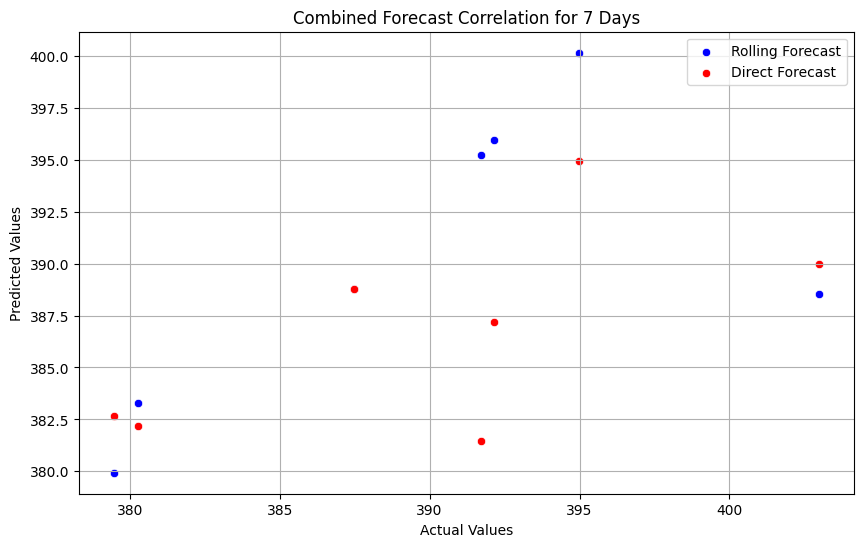

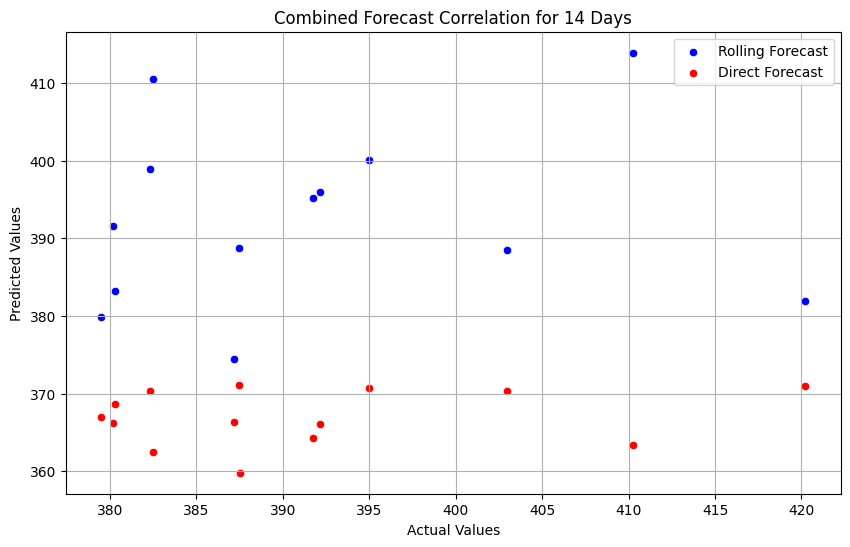

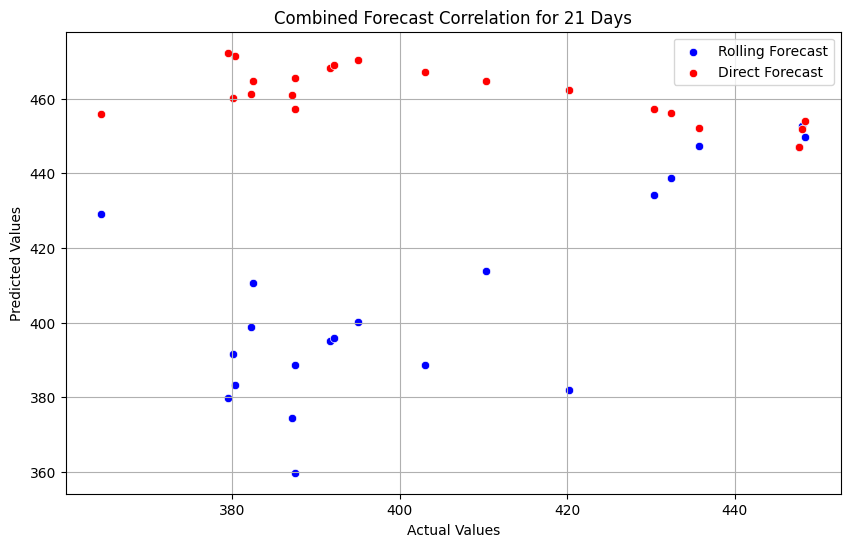

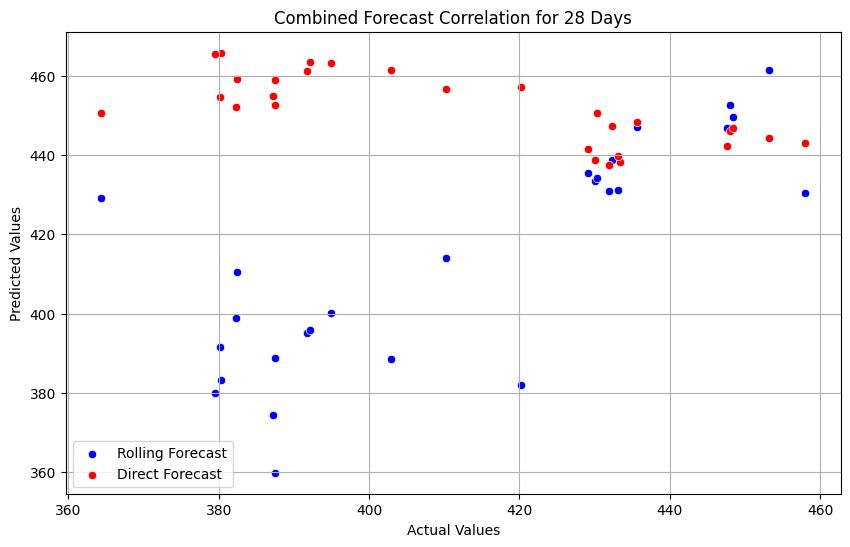

In [20]:
def plot_combined_correlations(rolling_predictions, direct_predictions, actual, horizon):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=actual, y=rolling_predictions, color='blue', label='Rolling Forecast')
    sns.scatterplot(x=actual, y=direct_predictions, color='red', label='Direct Forecast')
    plt.title(f'Combined Forecast Correlation for {horizon} Days')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.legend()
    plt.grid(True)
    plt.show()

# Ejecutar gráficos de correlación combinados para cada horizonte
for horizon in horizons:
    plot_combined_correlations(
        rolling_predictions=rolling_results[horizon]['Forecast'],
        direct_predictions=direct_results[horizon]['Forecast'],
        actual=close_prices[-horizon:],
        horizon=horizon
    )


En este caso, parece que las predicciones no están relativamente cerca de los valores reales y  hay cierta variabilidad.
El modelo parece estar capturando algunas tendencias, pero también hay errores en las predicciones
En resumen, la gráfica muestra cómo se comparan las predicciones del modelo con los valores reales en el conjunto de prueba. Si los puntos estuvieran más cerca de la línea diagonal, indicaría una correlación más fuerte entre las predicciones y los valores reales.

5.Repita el análisis desarrollado en los pasos anteriores, considerando ahora el criterio de inferencia Bayesiana (BIC) y el criterio de información de Hannan–Quinn (HQIC) para encontrar el mejor modelo ARIMA y, compare los errores con aquellos obtenidos con el criterio de Akaike.

Criterio BIC

In [21]:
best_bic = np.inf  # Mejor BIC inicializado a infinito
best_order_bic = None  # Mejor orden inicialmente a None
best_mdl_bic = None  # Mejor modelo inicialmente a None

pq_rng = range(8)  # Rango para los parámetros p y q
d_rng = range(3)   # Rango para el parámetro d

for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                # Ajustar el modelo ARIMA con la orden (i, d, j)
                tmp_mdl = ARIMA(train, order=(i, d, j)).fit()
                tmp_bic = tmp_mdl.bic  # Obtener el BIC del modelo temporal

                # Verificar si el BIC actual es el mejor encontrado hasta ahora
                if tmp_bic < best_bic:
                    best_bic = tmp_bic  # Actualizar el mejor BIC
                    best_order_bic = (i, d, j)  # Guardar la mejor orden
                    best_mdl_bic = tmp_mdl  # Guardar el mejor modelo
            except:
                continue  

# Después del ciclo, best_order_bic y best_mdl_bic contienen la mejor orden y modelo basados en BIC
print("Mejor BIC:", best_bic)
print("Mejor orden BIC:", best_order_bic)

Mejor BIC: 3577.2314509463577
Mejor orden BIC: (0, 1, 2)


In [22]:
def rolling_arima_forecast(close_prices, horizons):
    results = {}
    residualsro = []
    for horizon in horizons:
        history = close_prices[:-horizon].tolist()  # Asegúrate de que close_prices es una lista
        test = close_prices[-horizon:]
        predictions = []

        for t in range(len(test)):
            model = ARIMA(history, order=best_order_bic)
            model_fit = model.fit()
            yhat = model_fit.forecast()[0]
            predictions.append(yhat)
            history.append(test.iloc[t])  # Usar .iloc[t] para acceso posicional seguro en Pandas
            
        residualsro.extend(np.array(predictions) - np.array(test))
        accuracy = forecast_accuracy(np.array(predictions), test)
        results[horizon] = {'Forecast': predictions, 'Accuracy': accuracy}

    return results, residualsro

In [23]:
# Horizontes de pronóstico
horizons = [7, 14, 21, 28]

# Ejecutar el modelo ARIMA para cada horizonte y evaluar
rolling_results, rolling_residuals = rolling_arima_forecast(close_prices, horizons)  # Desempaquetar correctamente

# Mostrar los resultados
for horizon, acc in rolling_results.items():
    print(f"Accuracy for Horizon {horizon} days:\n{acc['Accuracy']}\n")  # Acceder solo al diccionario de accuracy

Accuracy for Horizon 7 days:
{'MAPE': 0.01686496357959577, 'MAE': 6.588956738437308, 'RMSE': 8.561523274856164, 'MSE': 73.2996807859038, 'R2': -0.24581954888134683}

Accuracy for Horizon 14 days:
{'MAPE': 0.03372371970936255, 'MAE': 13.32478608593208, 'RMSE': 17.28040995098235, 'MSE': 298.61256807400974, 'R2': -1.158469477381014}

Accuracy for Horizon 21 days:
{'MAPE': 0.0333625017520935, 'MAE': 13.007436126289322, 'RMSE': 20.376750102931336, 'MSE': 415.2119447573122, 'R2': 0.3796127879564841}

Accuracy for Horizon 28 days:
{'MAPE': 0.028760738665762973, 'MAE': 11.44147395010825, 'RMSE': 18.555615335640077, 'MSE': 344.31086048424123, 'R2': 0.5429963927518153}



- Horizonte de 7 días:
El R2 es negativo, aproximadamente -0.25. Esto sugiere que el modelo no se ajusta bien a los datos en este horizonte de tiempo. 

- Horizonte de 14 días:
El R2 es negativo, aproximadamente -1.16. Similar al caso anterior, el modelo no está funcionando bien para predecir los datos en este horizonte.

- Horizonte de 21 días:
El R2 es positivo, aproximadamente 0.38. Aunque no es muy alto, indica que el modelo tiene cierta capacidad para explicar la variabilidad en los datos.

- Horizonte de 28 días:
El R2 es positivo, aproximadamente 0.54. Este valor sugiere que el modelo tiene una mejor capacidad para predecir los datos en comparación con los horizontes anteriores.
Conclusión:

En general, el horizonte de 28 días muestra el mejor desempeño en términos de R2.

In [24]:
def arima_direct_forecast(close_prices, horizons):
    results = {}
    residuals_di = []  # List to store residuals
    for horizon in horizons:
        train = close_prices[:-horizon]
        test = close_prices[-horizon:]

        model_fit = ARIMA(train, order=best_order_bic).fit()
        forecasted_values = model_fit.forecast(steps=horizon)
        residuals_di.extend(np.array(forecasted_values) - np.array(test))
        accuracy = forecast_accuracy(np.array(forecasted_values), np.array(test))
        results[horizon] = {'Forecast': forecasted_values.tolist(), 'Accuracy': accuracy}

    return results, residuals_di

In [25]:
# Horizontes de pronóstico
horizons = [7, 14, 21, 28]

# Ejecutar el modelo ARIMA para cada horizonte y evaluar
direct_results, direct_residuals = arima_direct_forecast(close_prices, horizons)  # Correct unpacking

# Mostrar los resultados
for horizon, acc in direct_results.items():
    print(f"Accuracy for Horizon {horizon} days:\n{acc['Accuracy']}\n")  # Acceder solo al diccionario de accuracy

Accuracy for Horizon 7 days:
{'MAPE': 0.0196305321519561, 'MAE': 7.705905680055001, 'RMSE': 8.658830427490132, 'MSE': 74.97534437202894, 'R2': -0.27429954266250345}

Accuracy for Horizon 14 days:
{'MAPE': 0.05956175570601651, 'MAE': 23.62625239034883, 'RMSE': 26.40747710414675, 'MSE': 697.3548470060348, 'R2': -4.04070931064486}

Accuracy for Horizon 21 days:
{'MAPE': 0.11659644773345461, 'MAE': 45.315626494504826, 'RMSE': 52.22503021675011, 'MSE': 2727.4537811404625, 'R2': -3.0752138001431577}

Accuracy for Horizon 28 days:
{'MAPE': 0.06906659030932318, 'MAE': 27.134722241878666, 'RMSE': 34.31707166878355, 'MSE': 1177.6614079204264, 'R2': -0.5631093099406996}



- Horizonte de 7 días:
El R2 es negativo, aproximadamente -0.27. Esto sugiere que el modelo no se ajusta bien a los datos en este horizonte de tiempo. Los errores en las predicciones pueden estar afectando negativamente el desempeño.

- Horizonte de 14 días:
El R2 es negativo, aproximadamente -4.04. Similar al caso anterior, el modelo no está funcionando bien para predecir los datos en este horizonte. Los errores son significativos.

- Horizonte de 21 días:
El R2 es negativo, aproximadamente -3.08. Aunque hay una mejora en comparación con el horizonte de 14 días, aún no es satisfactorio.

- Horizonte de 28 días:
El R2 es negativo, aproximadamente -0.56. Aunque es mejor que el caso de 14 días, sigue siendo subóptimo.

En general, los modelos no están ajustando bien los datos en los horizontes de predicción más largos.

Criterio HQIC

In [26]:
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

best_hqic = np.inf  # Mejor HQIC inicializado a infinito
best_order_hqic = None  # Mejor orden inicialmente a None
best_mdl_hqic = None  # Mejor modelo inicialmente a None

pq_rng = range(8)  # Rango para los parámetros p y q
d_rng = range(3)   # Rango para el parámetro d

for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                # Ajustar el modelo ARIMA con la orden (i, d, j)
                tmp_mdl = ARIMA(train, order=(i, d, j)).fit()
                tmp_hqic = tmp_mdl.hqic  # Obtener el HQIC del modelo temporal

                # Verificar si el HQIC actual es el mejor encontrado hasta ahora
                if tmp_hqic < best_hqic:
                    best_hqic = tmp_hqic  # Actualizar el mejor HQIC
                    best_order_hqic = (i, d, j)  # Guardar la mejor orden
                    best_mdl_hqic = tmp_mdl  # Guardar el mejor modelo
            except:
                continue  # Ignorar las combinaciones de órdenes que causan errores

# Después del ciclo, best_order_hqic y best_mdl_hqic contienen la mejor orden y modelo basados en HQIC
print("Mejor HQIC:", best_hqic)
print("Mejor orden HQIC:", best_order_hqic)


Mejor HQIC: 3567.553160291157
Mejor orden HQIC: (4, 1, 2)


In [27]:
def rolling_arima_forecast(close_prices, horizons):
    results = {}
    residualsro = []
    for horizon in horizons:
        history = close_prices[:-horizon].tolist()  # Asegúrate de que close_prices es una lista
        test = close_prices[-horizon:]
        predictions = []

        for t in range(len(test)):
            model = ARIMA(history, order=best_order_hqic)
            model_fit = model.fit()
            yhat = model_fit.forecast()[0]
            predictions.append(yhat)
            history.append(test.iloc[t])  # Usar .iloc[t] para acceso posicional seguro en Pandas
            
        residualsro.extend(np.array(predictions) - np.array(test))
        accuracy = forecast_accuracy(np.array(predictions), test)
        results[horizon] = {'Forecast': predictions, 'Accuracy': accuracy}

    return results, residualsro

In [28]:
# Horizontes de pronóstico
horizons = [7, 14, 21, 28]

# Ejecutar el modelo ARIMA para cada horizonte y evaluar
rolling_results, rolling_residuals = rolling_arima_forecast(close_prices, horizons)  # Desempaquetar correctamente

# Mostrar los resultados
for horizon, acc in rolling_results.items():
    print(f"Accuracy for Horizon {horizon} days:\n{acc['Accuracy']}\n")  # Acceder solo al diccionario de accuracy

Accuracy for Horizon 7 days:
{'MAPE': 0.014119040381654704, 'MAE': 5.571676423671663, 'RMSE': 7.527061376441137, 'MSE': 56.656652964711945, 'R2': 0.037049478512894196}

Accuracy for Horizon 14 days:
{'MAPE': 0.03293923920628008, 'MAE': 13.017788090147459, 'RMSE': 17.15691775628878, 'MSE': 294.3598268960572, 'R2': -1.1277292708082722}

Accuracy for Horizon 21 days:
{'MAPE': 0.03294672046661341, 'MAE': 12.8768649449193, 'RMSE': 19.8851678902037, 'MSE': 395.41990202158826, 'R2': 0.40918498685032545}

Accuracy for Horizon 28 days:
{'MAPE': 0.0282857338164751, 'MAE': 11.268548832328813, 'RMSE': 18.063083785011237, 'MSE': 326.27499582433586, 'R2': 0.5669353855498482}



- Horizonte de 7 días:
El R2 es negativo, aproximadamente -0.27. Esto sugiere que el modelo no se ajusta bien a los datos en este horizonte de tiempo.

- Horizonte de 14 días:
El R2 es negativo, aproximadamente -4.04. Similar al caso anterior, el modelo no está funcionando bien para predecir los datos en este horizonte. Los errores son significativos.

- Horizonte de 21 días:
El R2 es negativo, aproximadamente -3.08. Aunque hay una mejora en comparación con el horizonte de 14 días, aún no es satisfactorio.

- Horizonte de 28 días:
El R2 es negativo, aproximadamente -0.56. Aunque es mejor que el caso de 14 días, sigue siendo subóptimo.

In [29]:
def arima_direct_forecast(close_prices, horizons):
    results = {}
    residuals_di = []  # List to store residuals
    for horizon in horizons:
        train = close_prices[:-horizon]
        test = close_prices[-horizon:]

        model_fit = ARIMA(train, order=best_order_hqic).fit()
        forecasted_values = model_fit.forecast(steps=horizon)
        residuals_di.extend(np.array(forecasted_values) - np.array(test))
        accuracy = forecast_accuracy(np.array(forecasted_values), np.array(test))
        results[horizon] = {'Forecast': forecasted_values.tolist(), 'Accuracy': accuracy}

    return results, residuals_di

In [30]:
# Horizontes de pronóstico
horizons = [7, 14, 21, 28]

# Ejecutar el modelo ARIMA para cada horizonte y evaluar
direct_results, direct_residuals = arima_direct_forecast(close_prices, horizons)  # Correct unpacking

# Mostrar los resultados
for horizon, acc in direct_results.items():
    print(f"Accuracy for Horizon {horizon} days:\n{acc['Accuracy']}\n")  # Acceder solo al diccionario de accuracy

Accuracy for Horizon 7 days:
{'MAPE': 0.01481029810706285, 'MAE': 5.822864386182963, 'RMSE': 7.512205004613044, 'MSE': 56.43322403133326, 'R2': 0.040846932062547414}

Accuracy for Horizon 14 days:
{'MAPE': 0.052291414256686486, 'MAE': 20.745997484631605, 'RMSE': 23.384405097355913, 'MSE': 546.8304017572452, 'R2': -2.9526693036057177}

Accuracy for Horizon 21 days:
{'MAPE': 0.11527602927048518, 'MAE': 44.795400345564325, 'RMSE': 51.69573205835411, 'MSE': 2672.4487130491407, 'R2': -2.9930282048771435}

Accuracy for Horizon 28 days:
{'MAPE': 0.06967882704795476, 'MAE': 27.36433425745586, 'RMSE': 34.59555191324797, 'MSE': 1196.8522121822352, 'R2': -0.588581253408605}



- Horizonte de 7 días:
El R2 es positivo, aproximadamente 0.04. Aunque no es muy alto, sugiere que el modelo tiene cierta capacidad para explicar la variabilidad en los datos en este horizonte de tiempo.

- Horizonte de 14 días:
El R2 es negativo, aproximadamente -2.95. Esto sugiere que el modelo no se ajusta bien a los datos en este horizonte.

- Horizonte de 21 días:
El R2 es negativo, aproximadamente -2.99. Similar al caso anterior, el modelo no está funcionando bien para predecir los datos en este horizonte.

- Horizonte de 28 días:
El R2 es negativo, aproximadamente -0.59. Aunque es mejor que el caso de 14 días, sigue siendo subóptimo.

En general, el horizonte de 7 días muestra el mejor desempeño en términos de R2.

En general el criterio AIC muestra mejores r2 y capacidad de predicción que los criterios BIC y HQIC, teniendo el valor r2 más alto para el horizonte de tiempo de 28 días de 0.56, seguido por el criterio BIC para el mismo horizonte con un r2 de 0.54

6. Escriba en cada paso las conclusiones y análisis estadísticos asociados con los resultados obtenidos. Realice tests de normalidad e independencia para los residuales obtenidos para cada predicción, en cada caso agregue las correspondientes conclusiones. Figuras y algoritmos que no estén acompañados de una conclusión, descripción y análisis estadístico, no serán tenidas en cuenta.

In [31]:
def rolling_arima_forecast(close_prices, horizons):
    results = {}
    residuals_per_horizon = {}  # Diccionario para almacenar residuales por horizonte
    for horizon in horizons:
        history = close_prices[:-horizon].tolist()  # Asegúrate de que close_prices es una lista o conviértela en lista
        test = close_prices[-horizon:]
        predictions = []

        for t in range(len(test)):
            model = ARIMA(history, order=best_order)
            model_fit = model.fit()
            yhat = model_fit.forecast()[0]
            predictions.append(yhat)
            # Corregido para usar .iloc[t] asegurando acceso por posición
            history.append(test.iloc[t])  # Acceso seguro por posición
        
        residuals = np.array(predictions) - np.array(test)
        residuals_per_horizon[horizon] = residuals
        accuracy = forecast_accuracy(np.array(predictions), test)
        results[horizon] = {'Forecast': predictions, 'Accuracy': accuracy}

    return results, residuals_per_horizon


In [32]:
# Ejecutar el modelo ARIMA para cada horizonte y evaluar
rolling_results, rolling_residuals = rolling_arima_forecast(close_prices, horizons)  # Desempaquetar correctamente

# Mostrar los resultados
for horizon, acc in rolling_results.items():
    print(f"Accuracy for Horizon {horizon} days:\n{acc['Accuracy']}\n")  # Acceder solo al diccionario de accuracy

Accuracy for Horizon 7 days:
{'MAPE': 0.011417750876158194, 'MAE': 4.519749198457995, 'RMSE': 6.233772925982728, 'MSE': 38.859924892715256, 'R2': 0.3395270814233109}

Accuracy for Horizon 14 days:
{'MAPE': 0.030802313966989826, 'MAE': 12.152123726538864, 'RMSE': 16.63517903679374, 'MSE': 276.7291815861819, 'R2': -1.0002891901266557}

Accuracy for Horizon 21 days:
{'MAPE': 0.032093766971680475, 'MAE': 12.536542388478546, 'RMSE': 19.86929673042893, 'MSE': 394.78895256183375, 'R2': 0.4101277173792033}

Accuracy for Horizon 28 days:
{'MAPE': 0.028356192820891392, 'MAE': 11.32265080943061, 'RMSE': 18.136203228786407, 'MSE': 328.92186755584254, 'R2': 0.5634221942217544}



In [33]:
from scipy.stats import shapiro
from statsmodels.stats.stattools import durbin_watson

# Asumiendo que rolling_residuals es un diccionario que contiene los residuales por cada horizonte
# Ejecutar pruebas para cada conjunto de residuales asociados a cada horizonte

for horizon, residuals in rolling_residuals.items():
    print(f"\nResultados de las pruebas para el horizonte de {horizon} días:")

    # Test de normalidad (Shapiro-Wilk)
    if residuals.size > 0:  # Verificar que haya residuales
        shapiro_test_statistic, shapiro_p_value = shapiro(residuals)
        print(f"Shapiro-Wilk Test Statistic: {shapiro_test_statistic:.3f}, p-value: {shapiro_p_value:.3f}")
        if shapiro_p_value > 0.05:
            print("Los residuales siguen una distribución normal.")
        else:
            print("Los residuales no siguen una distribución normal.")

        # Test de independencia (Durbin-Watson)
        durbin_watson_statistic = durbin_watson(residuals)
        print(f"Durbin-Watson Statistic: {durbin_watson_statistic:.3f}")
        if durbin_watson_statistic < 2 or durbin_watson_statistic > 3:
            print("Los residuales muestran autocorrelación.")
        else:
            print("Los residuales son independientes.")
    else:
        print("No hay residuales disponibles para analizar.")



Resultados de las pruebas para el horizonte de 7 días:
Shapiro-Wilk Test Statistic: 0.676, p-value: 0.002
Los residuales no siguen una distribución normal.
Durbin-Watson Statistic: 2.134
Los residuales son independientes.

Resultados de las pruebas para el horizonte de 14 días:
Shapiro-Wilk Test Statistic: 0.925, p-value: 0.259
Los residuales siguen una distribución normal.
Durbin-Watson Statistic: 2.461
Los residuales son independientes.

Resultados de las pruebas para el horizonte de 21 días:
Shapiro-Wilk Test Statistic: 0.851, p-value: 0.004
Los residuales no siguen una distribución normal.
Durbin-Watson Statistic: 2.653
Los residuales son independientes.

Resultados de las pruebas para el horizonte de 28 días:
Shapiro-Wilk Test Statistic: 0.831, p-value: 0.000
Los residuales no siguen una distribución normal.
Durbin-Watson Statistic: 2.674
Los residuales son independientes.


Basandose en los resultados obtenidos y considerando tanto el R2 como otros indicadores de precisión, podemos concluir lo siguiente:

El modelo Rolling parece tener un mejor desempeño en términos de R2 en comparación con el modelo directo en todos los horizontes de tiempo.

In [34]:
def arima_direct_forecast(close_prices, horizons):
    results = {}
    residuals_per_horizon = {}  # Diccionario para almacenar residuales por horizonte

    for horizon in horizons:
        train = close_prices[:-horizon]  # Datos de entrenamiento
        test = close_prices[-horizon:]   # Datos de prueba
        model_fit = ARIMA(train, order=best_order).fit()
        forecasted_values = model_fit.forecast(steps=horizon)

        # Calcula residuales como diferencia entre pronósticos y valores reales
        residuals = np.array(forecasted_values) - np.array(test)
        residuals_per_horizon[horizon] = residuals

        # Calcular y almacenar precisión de los pronósticos
        accuracy = forecast_accuracy(np.array(forecasted_values), np.array(test))
        results[horizon] = {'Forecast': forecasted_values.tolist(), 'Accuracy': accuracy}

    return results, residuals_per_horizon

In [35]:
# Horizontes de pronóstico
horizons = [7, 14, 21, 28]

# Ejecutar el modelo ARIMA para cada horizonte y evaluar
direct_results, direct_residuals = arima_direct_forecast(close_prices, horizons)  # Desempaquetar correctamente

# Mostrar los resultados
for horizon, acc in direct_results.items():
    print(f"Accuracy for Horizon {horizon} days:\n{acc['Accuracy']}\n")

Accuracy for Horizon 7 days:
{'MAPE': 0.012585652271631336, 'MAE': 4.9578063105097625, 'RMSE': 6.707357760444587, 'MSE': 44.98864812659623, 'R2': 0.23536178175776912}

Accuracy for Horizon 14 days:
{'MAPE': 0.06157581637240981, 'MAE': 24.40020010498254, 'RMSE': 27.004049516535307, 'MSE': 729.2186902914907, 'R2': -4.271031609559828}

Accuracy for Horizon 21 days:
{'MAPE': 0.1471853208913676, 'MAE': 57.367099115907834, 'RMSE': 65.09073283340784, 'MSE': 4236.803500790078, 'R2': -5.330402448724532}

Accuracy for Horizon 28 days:
{'MAPE': 0.10526133329815436, 'MAE': 41.21229018152836, 'RMSE': 51.92213368841914, 'MSE': 2695.9079667580695, 'R2': -2.578277094962406}



In [36]:
from scipy.stats import shapiro
from statsmodels.stats.stattools import durbin_watson

# Asumiendo que rolling_residuals es un diccionario que contiene los residuales por cada horizonte
# Ejecutar pruebas para cada conjunto de residuales asociados a cada horizonte

for horizon, residuals in direct_residuals.items():
    print(f"\nResultados de las pruebas para el horizonte de {horizon} días:")

    # Test de normalidad (Shapiro-Wilk)
    if residuals.size > 0:  # Verificar que haya residuales
        shapiro_test_statistic, shapiro_p_value = shapiro(residuals)
        print(f"Shapiro-Wilk Test Statistic: {shapiro_test_statistic:.3f}, p-value: {shapiro_p_value:.3f}")
        if shapiro_p_value > 0.05:
            print("Los residuales siguen una distribución normal.")
        else:
            print("Los residuales no siguen una distribución normal.")

        # Test de independencia (Durbin-Watson)
        durbin_watson_statistic = durbin_watson(residuals)
        print(f"Durbin-Watson Statistic: {durbin_watson_statistic:.3f}")
        if durbin_watson_statistic < 2 or durbin_watson_statistic > 3:
            print("Los residuales muestran autocorrelación.")
        else:
            print("Los residuales son independientes.")
    else:
        print("No hay residuales disponibles para analizar.")



Resultados de las pruebas para el horizonte de 7 días:
Shapiro-Wilk Test Statistic: 0.873, p-value: 0.198
Los residuales siguen una distribución normal.
Durbin-Watson Statistic: 0.857
Los residuales muestran autocorrelación.

Resultados de las pruebas para el horizonte de 14 días:
Shapiro-Wilk Test Statistic: 0.881, p-value: 0.059
Los residuales siguen una distribución normal.
Durbin-Watson Statistic: 0.275
Los residuales muestran autocorrelación.

Resultados de las pruebas para el horizonte de 21 días:
Shapiro-Wilk Test Statistic: 0.854, p-value: 0.005
Los residuales no siguen una distribución normal.
Durbin-Watson Statistic: 0.090
Los residuales muestran autocorrelación.

Resultados de las pruebas para el horizonte de 28 días:
Shapiro-Wilk Test Statistic: 0.873, p-value: 0.003
Los residuales no siguen una distribución normal.
Durbin-Watson Statistic: 0.120
Los residuales muestran autocorrelación.


Dado que la autocorrelación persiste en todos los horizontes, podría ser preferible elegir el modelo con menor autocorrelación.
En este caso, el horizonte de 21 días muestra una combinación aceptable de normalidad y baja autocorrelación.